In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 11 - Signal detection theory
  
The basic data for an SDT analysis are  the counts of hits, false alarms, misses, and correct rejections. It is common to consider just the hit and false alarm counts which, together with the total number of signal and noise trials, completely describe the data.

|                  |   Signal trial   |   Noise trial    |
|:----------------:|:----------------:|:----------------:|
| Yes response     |        Hit       |   False alarm    |
| No response      |       Miss       |Correct rejection | 

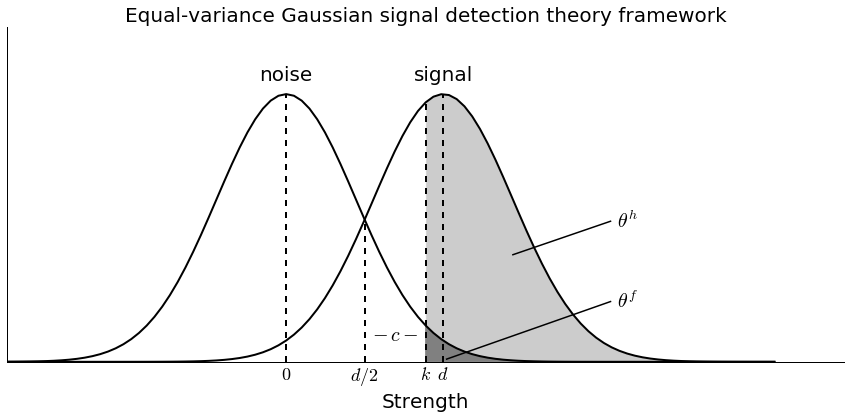

In [2]:
from matplotlib.patches import Polygon

func = stats.norm.pdf

a, b, d = 2, 7, 2.25  # integral limits 1
x = np.linspace(-4, b,100)
y = func(x)
y2 = func(x,loc=d)

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(x, y, 'k', linewidth=2)
plt.plot(x, y2, 'k', linewidth=2)
d2 = x[y==y2]

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
iy2 = func(ix,loc=d)

verts = [(a, 0)] + list(zip(ix, iy2)) + [(b, 0)]
poly = Polygon(verts, facecolor='.8', edgecolor='1')
ax.add_patch(poly)

verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='.5', edgecolor='0.5')
ax.add_patch(poly)

plt.text(0, y.max()+.02, "noise",
         horizontalalignment='center', fontsize=20)
plt.text(d, y.max()+.02, "signal",
         horizontalalignment='center', fontsize=20)
plt.text((d/2+a)/2, y.max()*.08, r"$ - \,c - $",
         horizontalalignment='center', fontsize=20)
plt.text(b*.7, y.max()*.5, r"$\theta^h$",
         horizontalalignment='center', fontsize=20)
plt.text(b*.7, y.max()*.2, r"$\theta^f$",
         horizontalalignment='center', fontsize=20)
plt.plot([d+1,b*.7-.25],[y.max()*.4,y.max()*.5+.01], color='k', linestyle='-', linewidth=1.5)
plt.plot([d+.05,b*.7-.25],[y.max()*.01,y.max()*.2+.01], color='k', linestyle='-', linewidth=1.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

plt.plot([0,0],[0,func(0)], color='k', linestyle='--', linewidth=2)
plt.plot([d/2,d/2],[0,func(d/2)], color='k', linestyle='--', linewidth=2)
plt.plot([a,a],[0,func(a,loc=d)], color='k', linestyle='--', linewidth=2)
plt.plot([d,d],[0,func(d,loc=d)], color='k', linestyle='--', linewidth=2)

ax.set_xticks((0, a, d, d/2))
ax.set_xticklabels(('$0$','$k$', '$d$','$d/2$'),fontsize=18)
ax.set_yticks([])
plt.ylim(0,y.max()+.1)
plt.title('Equal-variance Gaussian signal detection theory framework',fontsize=20)
plt.xlabel('Strength',fontsize=20)
plt.show()

## 11.1 Signal detection theory


$$ d_{i} \sim \text{Gaussian}(0,\frac{1}{2})$$
$$ c_{i} \sim \text{Gaussian}(0,2)$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

Assigned NUTS to Discriminability
Assigned NUTS to Bias
 [-----------------100%-----------------] 10000 of 10000 complete in 5.0 sec

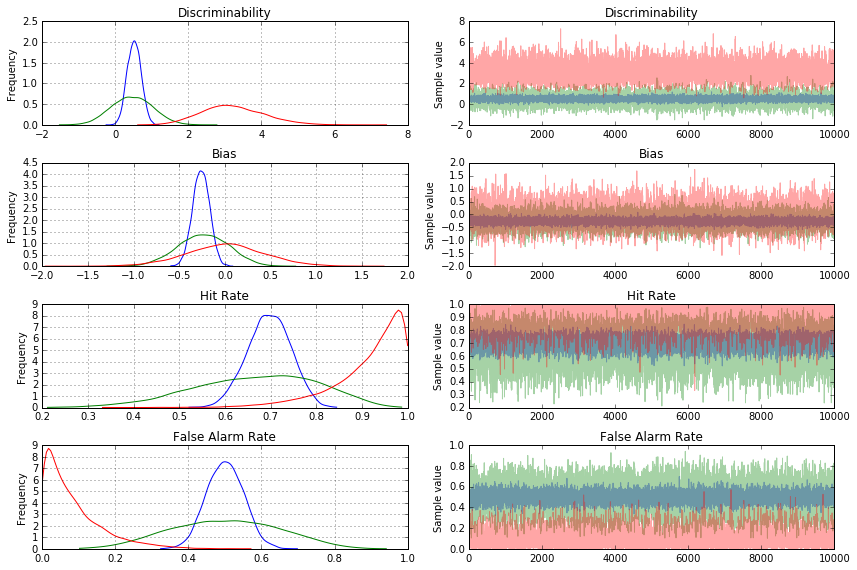

In [3]:
# Load data
dataset = 1
if dataset==1:  # Demo
    k = 3 # number of cases
    data =np.array([70, 50, 30, 50,
                    7,  5,  3,  5, 
                10,  0,  0, 10]).reshape(k,-1)
else:  # Lehrner et al. (1995) data 
    k = 3 # number of cases
    data =np.array([148, 29, 32, 151,
                   150, 40, 30, 140,
                   150, 51, 40, 139]).reshape(k,-1)
    
h  = data[:, 0]
f  = data[:, 1]
MI = data[:, 2]
CR = data[:, 3]
s = h + MI
n = f + CR

with pm.Model() as model1:
    di = pm.Normal("Discriminability",mu=0,tau=.5,shape= k)
    ci = pm.Normal("Bias",mu=0,tau=2, shape= k)
    
    def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + T.erf(x / T.sqrt(2.0))) / 2.0
    thetah = pm.Deterministic("Hit Rate",Phi(di/2-ci))
    thetaf = pm.Deterministic("False Alarm Rate",Phi(-di/2-ci))
    
    hi = pm.Binomial("hi",p=thetah,n=s,observed=h)
    fi = pm.Binomial("fi",p=thetaf,n=n,observed=f)
    trace1=pm.sample(1e4, model=model1)

burnin=0    
pm.traceplot(trace1[burnin:],varnames=['Discriminability','Bias','Hit Rate','False Alarm Rate']);
plt.show()

## 11.2 Hierarchical signal detection theory
  
$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ d_{i} \sim \text{Gaussian}(\mu_{d},\lambda_{d})$$
$$ c_{i} \sim \text{Gaussian}(\mu_{c},\lambda_{c})$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [4]:
# Load data using rpy2
from rpy2 import *
%load_ext rpy2.ipython
%R source("data/heit_rotello.RData") -o std_i -o std_d 
# the induction data and the deduction data

h1  = np.array(std_i['V1'])
f1  = np.array(std_i['V2'])
MI1 = np.array(std_i['V3'])
CR1 = np.array(std_i['V4'])
s1 = h1 + MI1
n1 = f1 + CR1

h2  = np.array(std_d['V1'])
f2  = np.array(std_d['V2'])
MI2 = np.array(std_d['V3'])
CR2 = np.array(std_d['V4'])
s2 = h2 + MI2
n2 = f2 + CR2

k=len(h1)

In [5]:
with pm.Model() as model2i:
    mud = pm.Normal("mud",mu=0,tau=.001)
    muc = pm.Normal("muc",mu=0,tau=.001)
    lambdad = pm.Gamma("lambdad",alpha=.001,beta=.001)
    lambdac = pm.Gamma("lambdac",alpha=.001,beta=.001)
    
    di = pm.Normal("di",mu=mud,tau=lambdad,shape= k)
    ci = pm.Normal("ci",mu=muc,tau=lambdac, shape= k)
    
    def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + T.erf(x / T.sqrt(2.0))) / 2.0
    thetah = pm.Deterministic("Hit Rate",Phi(di/2-ci))
    thetaf = pm.Deterministic("False Alarm Rate",Phi(-di/2-ci))

    hi = pm.Binomial("hi",p=thetah,n=s1,observed=h1)
    fi = pm.Binomial("fi",p=thetaf,n=n1,observed=f1)
    trace_i=pm.sample(3e3, model=model2i)
    
with pm.Model() as model2d:
    mud = pm.Normal("mud",mu=0,tau=.001)
    muc = pm.Normal("muc",mu=0,tau=.001)
    lambdad = pm.Gamma("lambdad",alpha=.001,beta=.001)
    lambdac = pm.Gamma("lambdac",alpha=.001,beta=.001)
    
    di = pm.Normal("di",mu=mud,tau=lambdad,shape= k)
    ci = pm.Normal("ci",mu=muc,tau=lambdac, shape= k)
    
    def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + T.erf(x / T.sqrt(2.0))) / 2.0
    thetah = pm.Deterministic("Hit Rate",Phi(di/2-ci))
    thetaf = pm.Deterministic("False Alarm Rate",Phi(-di/2-ci))

    hi = pm.Binomial("hi",p=thetah,n=s2,observed=h2)
    fi = pm.Binomial("fi",p=thetaf,n=n2,observed=f2)
    trace_d=pm.sample(3e3, model=model2d)
    

Applied log-transform to lambdad and added transformed lambdad_log to model.
Applied log-transform to lambdac and added transformed lambdac_log to model.
Assigned NUTS to mud
Assigned NUTS to muc
Assigned NUTS to lambdad_log
Assigned NUTS to lambdac_log
Assigned NUTS to di
Assigned NUTS to ci
 [-----------------100%-----------------] 3000 of 3000 complete in 477.9 secApplied log-transform to lambdad and added transformed lambdad_log to model.
Applied log-transform to lambdac and added transformed lambdac_log to model.
Assigned NUTS to mud
Assigned NUTS to muc
Assigned NUTS to lambdad_log
Assigned NUTS to lambdac_log
Assigned NUTS to di
Assigned NUTS to ci
 [-----------------100%-----------------] 3001 of 3000 complete in 525.5 sec

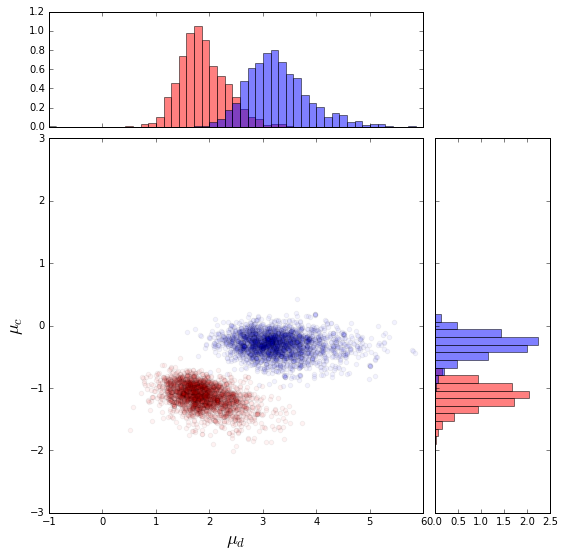

In [16]:
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels

burnin=500 # set to zero to plot the one without burnin

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# now determine limits by hand:
binwidth1 = 0.25
    
# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

cc = np.array([[1,0,0],[0,0,1]])

for idd in np.arange(2):
    if idd==0:
        x = trace_i['mud'][burnin:]
        y = trace_i['muc'][burnin:]
    else:
        x = trace_d['mud'][burnin:]
        y = trace_d['muc'][burnin:]
        
    axScatter = plt.axes(rect_scatter)
    axScatter.set_xlim((-1, 6))
    axScatter.set_ylim((-3, 3))

    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y,c=cc[idd,:],alpha=.05)
    axScatter.set_xlabel(r'$\mu_d$',fontsize=18)
    axScatter.set_ylabel(r'$\mu_c$',fontsize=18)
    
    bins1 = np.linspace(-1, 6, 50)
    axHistx.hist(x, bins=bins1,color=cc[idd,:],alpha=.5,normed=True)
    bins2 = np.linspace(-3, 3, 50)
    axHisty.hist(y, bins=bins2, color=cc[idd,:],alpha=.5,normed=True, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    
plt.show()


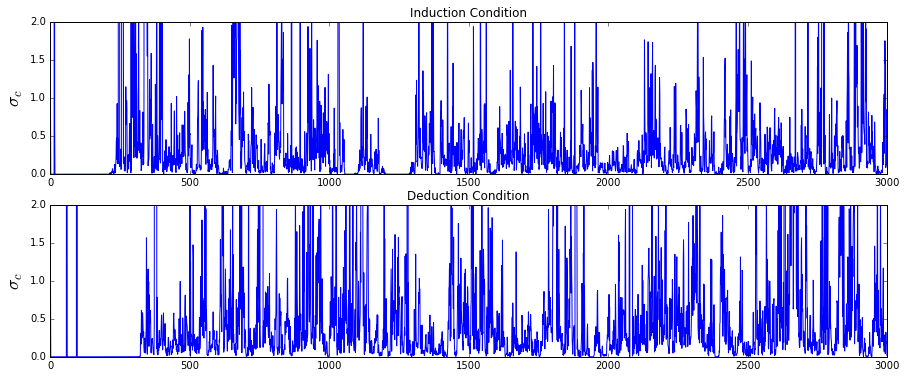

In [15]:
tmptrace = trace_i['lambdac'][:]
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2,1)
plt.subplot(gs[0])
plt.plot(1/tmptrace**2)
plt.ylim(0,2)
plt.title('Induction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.subplot(gs[1])
tmptrace = trace_d['lambdac'][:]
plt.plot(1/tmptrace**2)
plt.ylim(0,2)
plt.title('Deduction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.show()

## 11.3 Parameter expansion
  
  
Using parameter expansion to escape the "zero variance trap" in MCMC sampling.  

$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ \xi_{d},\xi_{c} \sim \text{Beta}(1,1)$$
$$ \delta_{d_{i}} \sim \text{Gaussian}(0,\lambda_{d})$$
$$ \delta_{c_{i}} \sim \text{Gaussian}(0,\lambda_{c})$$
$$ \sigma_{d} = \lvert \xi_{d}\rvert\,/\,\sqrt\lambda_{d}$$
$$ \sigma_{c} = \lvert \xi_{c}\rvert\,/\,\sqrt\lambda_{c}$$
$$ d_{i} = \mu_{d} + \xi_{d}\delta_{d_{i}}$$
$$ c_{i} = \mu_{c} + \xi_{c}\delta_{c_{i}}$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [27]:
with pm.Model() as model3i:
    mud = pm.Normal("mud",mu=0,tau=.001)
    muc = pm.Normal("muc",mu=0,tau=.001)
    lambdad = pm.Gamma("lambdad",alpha=.001,beta=.001)
    lambdac = pm.Gamma("lambdac",alpha=.001,beta=.001)
    xid = pm.Uniform("xid",lower=0,upper=1)
    xic = pm.Uniform("xic",lower=0,upper=1)
    deltadi = pm.Normal("deltadi",mu=0,tau=lambdad,shape=k)
    deltaci = pm.Normal("deltaci",mu=0,tau=lambdac,shape=k)
    
    sigmad = pm.Deterministic("sigmad",xid/T.sqrt(lambdad))
    sigmac = pm.Deterministic("sigmac",xic/T.sqrt(lambdac))
    
    di = pm.Deterministic("di",mud+xid*deltadi)
    ci = pm.Deterministic("ci",muc+xic*deltaci)
    
    def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + T.erf(x / T.sqrt(2.0))) / 2.0
    thetah = pm.Deterministic("Hit Rate",Phi(di/2-ci))
    thetaf = pm.Deterministic("False Alarm Rate",Phi(-di/2-ci))

    hi = pm.Binomial("hi",p=thetah,n=s1,observed=h1)
    fi = pm.Binomial("fi",p=thetaf,n=n1,observed=f1)
    trace_i2=pm.sample(1e4, step=pm.Metropolis(), model=model3i)
    
with pm.Model() as model3d:
    mud = pm.Normal("mud",mu=0,tau=.001)
    muc = pm.Normal("muc",mu=0,tau=.001)
    lambdad = pm.Gamma("lambdad",alpha=.001,beta=.001)
    lambdac = pm.Gamma("lambdac",alpha=.001,beta=.001)
    xid = pm.Uniform("xid",lower=0,upper=1)
    xic = pm.Uniform("xic",lower=0,upper=1)
    deltadi = pm.Normal("deltadi",mu=0,tau=lambdad,shape=k)
    deltaci = pm.Normal("deltaci",mu=0,tau=lambdac,shape=k)
    
    sigmad = pm.Deterministic("sigmad",xid/T.sqrt(lambdad))
    sigmac = pm.Deterministic("sigmac",xic/T.sqrt(lambdac))
    
    di = pm.Deterministic("di",mud+xid*deltadi)
    ci = pm.Deterministic("ci",muc+xic*deltaci)
    
    def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + T.erf(x / T.sqrt(2.0))) / 2.0
    thetah = pm.Deterministic("Hit Rate",Phi(di/2-ci))
    thetaf = pm.Deterministic("False Alarm Rate",Phi(-di/2-ci))

    hi = pm.Binomial("hi",p=thetah,n=s2,observed=h2)
    fi = pm.Binomial("fi",p=thetaf,n=n2,observed=f2)
    trace_d2=pm.sample(1e4, step=pm.Metropolis(), model=model3d)
    

Applied log-transform to lambdad and added transformed lambdad_log to model.
Applied log-transform to lambdac and added transformed lambdac_log to model.
Applied interval-transform to xid and added transformed xid_interval to model.
Applied interval-transform to xic and added transformed xic_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 9.2 secApplied log-transform to lambdad and added transformed lambdad_log to model.
Applied log-transform to lambdac and added transformed lambdac_log to model.
Applied interval-transform to xid and added transformed xid_interval to model.
Applied interval-transform to xic and added transformed xic_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 11.2 sec

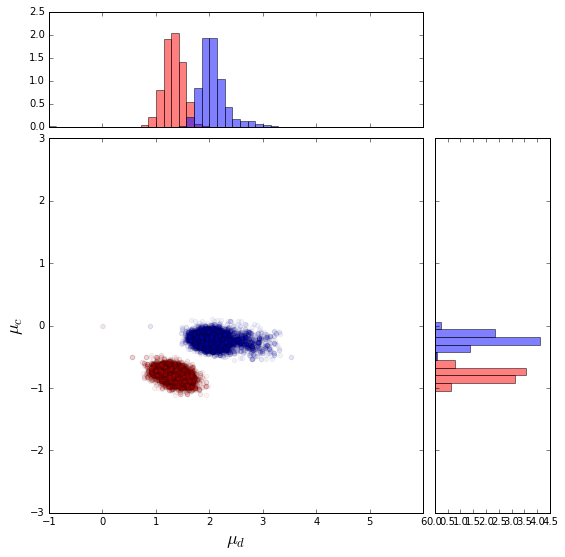

In [32]:
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels

burnin=0 # set to zero to plot the one without burnin

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# now determine limits by hand:
binwidth1 = 0.25
    
# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

cc = np.array([[1,0,0],[0,0,1]])

for idd in np.arange(2):
    if idd==0:
        x = trace_i2['mud'][burnin:]
        y = trace_i2['muc'][burnin:]
    else:
        x = trace_d2['mud'][burnin:]
        y = trace_d2['muc'][burnin:]
        
    axScatter = plt.axes(rect_scatter)
    axScatter.set_xlim((-1, 6))
    axScatter.set_ylim((-3, 3))

    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y,c=cc[idd,:],alpha=.05)
    axScatter.set_xlabel(r'$\mu_d$',fontsize=18)
    axScatter.set_ylabel(r'$\mu_c$',fontsize=18)
    
    bins1 = np.linspace(-1, 6, 50)
    axHistx.hist(x, bins=bins1,color=cc[idd,:],alpha=.5,normed=True)
    bins2 = np.linspace(-3, 3, 50)
    axHisty.hist(y, bins=bins2, color=cc[idd,:],alpha=.5,normed=True, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    
plt.show()


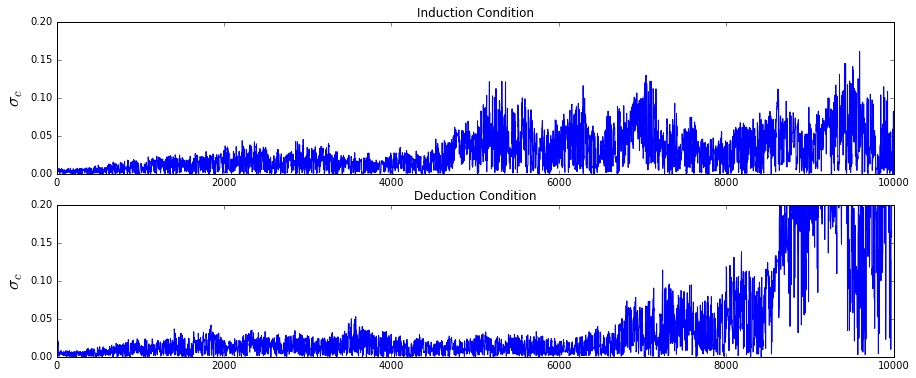

In [31]:
tmptrace = trace_i2['sigmac'][:]
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2,1)
plt.subplot(gs[0])
plt.plot(tmptrace)
plt.ylim(0,.2)
plt.title('Induction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.subplot(gs[1])
tmptrace = trace_d2['sigmac'][:]
plt.plot(tmptrace)
plt.ylim(0,.2)
plt.title('Deduction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.show()